# ||| Loading important modules and data |||

In [1]:
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
import time, os
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import boxcox1p
from scipy.stats import norm, skew

from sklearn.preprocessing import StandardScaler, RobustScaler

from IPython.display import display
pd.options.display.max_rows = 1000

input_file_path = '../../../.kaggle/competitions/house-prices-advanced-regression-techniques'

sample_submission = pd.read_csv(input_file_path + '/sample_submission.csv')
train = pd.read_csv(input_file_path + '/train.csv')
test = pd.read_csv(input_file_path + '/test.csv')

quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')

qualitative = [f for f in train.columns if train.dtypes[f] == 'object']

from subprocess import check_output
print(check_output(["ls", input_file_path]).decode("utf8"))

data_description.txt
sample_submission.csv
sample_submission.csv.gz
test.csv
test.csv.gz
train.csv
train.csv.gz



In [2]:
train_ID = train['Id']
test_ID = test['Id']

train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

print('train shape: {}'.format(train.shape))
print('test shape: {} \n'.format(test.shape))

print('Quantitative Features: {} \n \n {} \n'.format(len(quantitative), quantitative))
print('Qualitative Features: {} \n \n {} \n'.format(len(qualitative), qualitative))

train shape: (1460, 80)
test shape: (1459, 79) 

Quantitative Features: 36 
 
 ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'] 

Qualitative Features: 43 
 
 ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'E

# | Exploratory Data Analysis |

## Univariate Analysis

Univariate analysis is also used to highlight missing and outlier values.

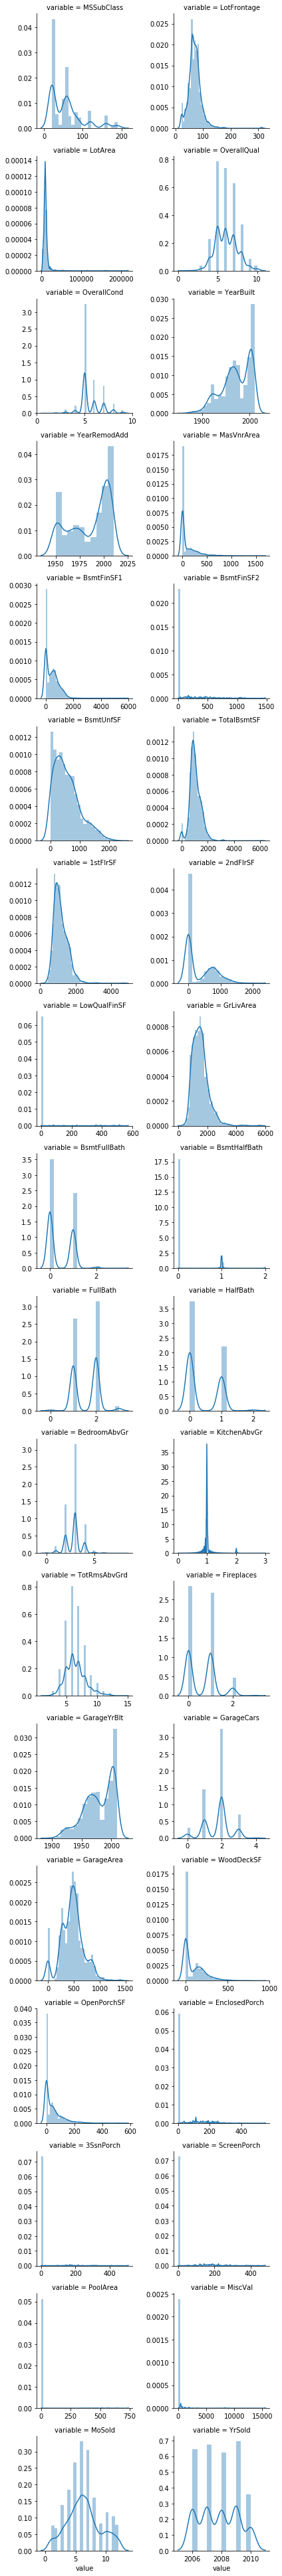

In [3]:
f = pd.melt(train, value_vars = quantitative)
g = sns.FacetGrid(f, col = 'variable', col_wrap = 2, sharex = False, sharey = False )
g.map(sns.distplot, "value")

## Bivariate Analysis

#### Numerical Feature

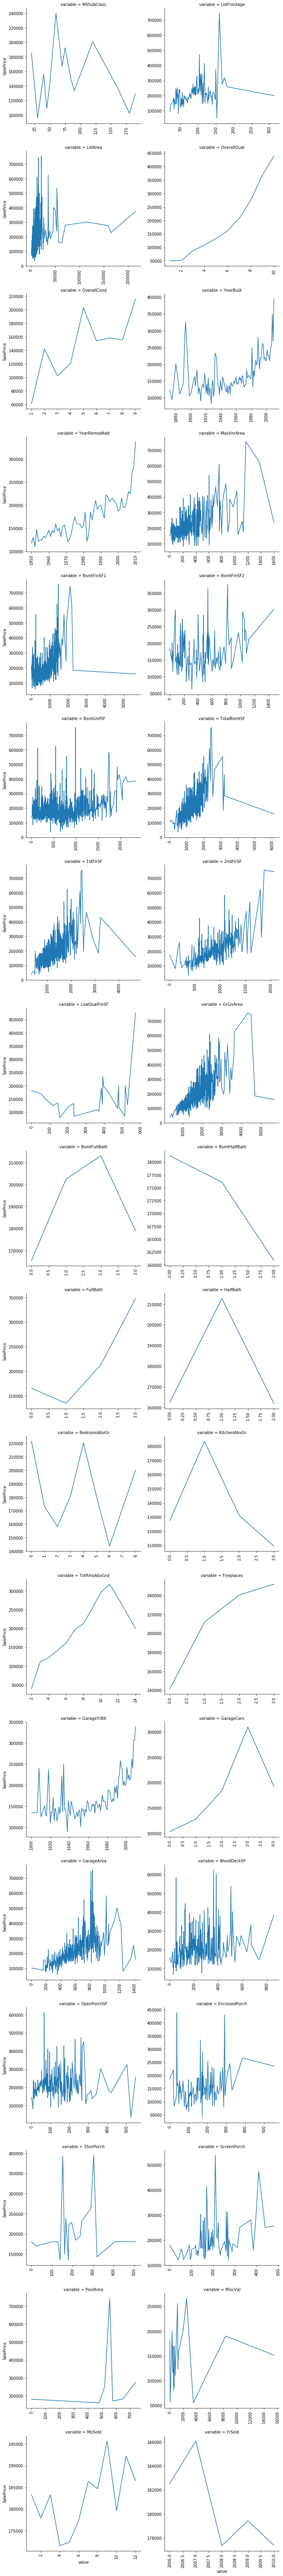

In [4]:
def pairplot(x, y, **kwargs):
    ax = plt.gca()
    ts = pd.DataFrame({'time': x, 'val': y})
    ts = ts.groupby('time').mean()
    ts.plot(ax=ax)
    plt.xticks(rotation=90)
    
f = pd.melt(train, id_vars=['SalePrice'], value_vars=quantitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(pairplot, "value", "SalePrice")

#### Categorical Feature

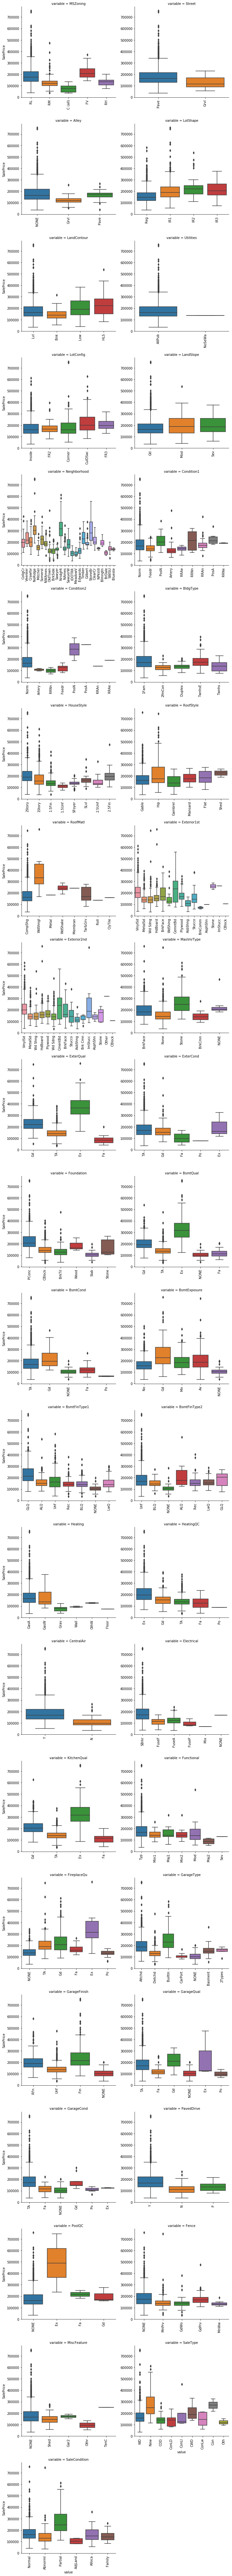

In [5]:
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x = plt.xticks(rotation=90)

f = pd.melt(train.fillna("NONE"), id_vars=['SalePrice'], value_vars = qualitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(boxplot, "value", "SalePrice")

## Outlier Detection

Outliers is also something that we should be aware of. Why? Because outliers can markedly affect our models and can be a valuable source of information, providing us insights about specific behaviours.

Outliers removal is note always safe. There are few outliers in our training data. However, removing all them may affect badly our models if ever there were also outliers in the test data. That's why, instead of removing them all, we will just manage to make some of our models robust on them. 

Documentation for the Ames Housing Data indicates that there are outliers present in the training data

#### Ames Housing Data Documentation :

Although all known errors were corrected in the data, no
observations have been removed due to unusual values and all final residential sales
from the initial data set are included in the data presented with this article. There are
five observations that an instructor may wish to remove from the data set before giving
it to students (a plot of SALE PRICE versus GR LIV AREA will quickly indicate these
points). Three of them are true outliers (Partial Sales that likely don’t represent actual
market values) and two of them are simply unusual sales (very large houses priced
relatively appropriately). I would recommend removing any houses with more than
4000 square feet from the data set (which eliminates these five unusual observations)
before assigning it to students

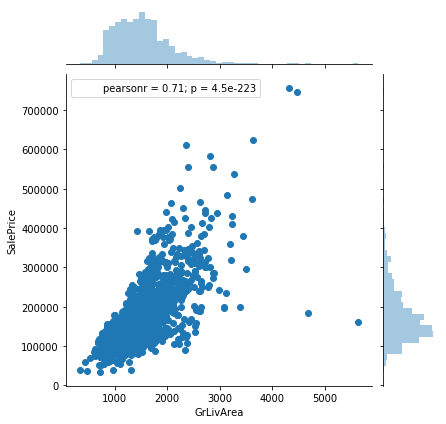

In [6]:
# checking outlier based on GrLivArea values
sns.jointplot(x = 'GrLivArea', y = 'SalePrice', data = train, kind = 'scatter')

We can see at the bottom right two with extremely large GrLivArea that are of a low price. These values are huge oultliers. Therefore, we can safely delete them.

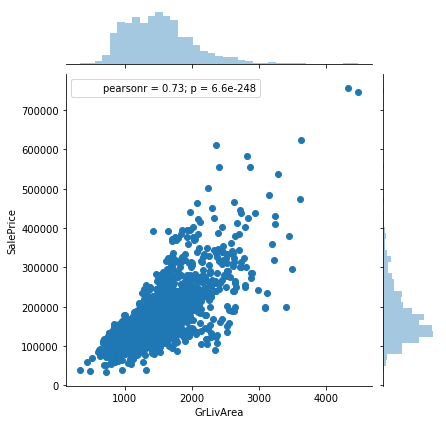

In [7]:
train.drop(train[(train.GrLivArea > 4000) & (train.SalePrice < 300000)].index, inplace = True)
#checking the graph again
sns.jointplot(x = 'GrLivArea', y = 'SalePrice', data = train, kind = 'scatter')

## # Imputing missing values
Lets concatenate the train and test data in same data frame

In [8]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice
all_data = pd.concat((train, test)).reset_index(drop = True)
all_data.drop(['SalePrice'], axis = 1, inplace = True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


In [9]:
#missing data
total = all_data.isnull().sum().sort_values(ascending=False)
percent = (100*all_data.isnull().sum()/all_data.isnull().count()).sort_values(ascending=False)

missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.drop(missing_data[missing_data.Total == 0].index, inplace = True )
missing_data

,Total,Percent
PoolQC,2908,99.691464
MiscFeature,2812,96.400411
Alley,2719,93.212204
Fence,2346,80.425094
FireplaceQu,1420,48.680151
LotFrontage,486,16.660953
GarageFinish,159,5.450806
GarageQual,159,5.450806
GarageYrBlt,159,5.450806
GarageCond,159,5.450806


__Note__ : <font color=blue>_We impute them by proceeding sequentially through features with missing values_ </font>

- __PoolQC__ : _data description says NA means "No Pool"_

In [10]:
all_data.PoolQC = all_data.PoolQC.fillna('None') 

- __MiscFeature__ : _data description says NA means "no misc feature"_

In [11]:
all_data.MiscFeature = all_data.MiscFeature.fillna('None')

- __Alley__ : _data description says NA means "no misc feature"_

In [12]:
all_data.Alley = all_data.Alley.fillna('None')

- __Fence__ : _data description says NA means "no fence"_

In [13]:
all_data.Fence = all_data.Fence.fillna("None")

- __FireplaceQu__ : _data description says NA means "no fireplace"_

In [14]:
all_data.FireplaceQu = all_data.FireplaceQu.fillna("None")

- __LotFrontage__ : _Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can fill in missing values by the median LotFrontage of the neighborhood._

In [15]:
all_data.LotFrontage = all_data.groupby("Neighborhood").LotFrontage.transform(lambda x: x.fillna(x.median()))

- __GarageType, GarageFinish, GarageQual and GarageCond__ : _Replacing missing data with None_

In [16]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

- __GarageYrBlt, GarageArea and GarageCars__ : _Replacing missing data with 0 (Since No garage = no cars in such garage.)_

In [17]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

- __BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath__ : _missing values are likely zero for having no basement_

In [18]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

- __BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2__ : _For all these categorical basement-related features, NaN means that there is no basement._

In [19]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

- __MasVnrArea and MasVnrType__ : _NA most likely means no masonry veneer for these houses. We can fill 0 for the area and None for the type._

In [20]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

- __MSZoning (The general zoning classification)__ : _'RL' is by far the most common value. So we can fill in missing values with 'RL'_

In [21]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

- __Utilities__ : _For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA . Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. We can then safely remove it._

In [22]:
all_data = all_data.drop(['Utilities'], axis=1)

- __Functional__ : _data description says NA means typical_

In [23]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")

- __Electrical__ : _It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value._

In [24]:
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

- __KitchenQual__ : _Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent) for the missing value in KitchenQual.
_

In [25]:
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

- __Exterior1st and Exterior2nd__ : _Again Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string_

In [26]:
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

- __SaleType__ : _Fill in again with most frequent which is "WD"_

In [27]:
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

In [28]:
missing_values = pd.DataFrame(all_data.isnull().sum().sort_values(ascending=False))
missing_values.drop(missing_values[missing_values == 0].index, inplace = True)
print('Missing Values: \n' + str(missing_values))

Missing Values: 
Empty DataFrame
Columns: [0]
Index: []


## Target Variable
SalePrice is the variable we need to predict. So let's do some analysis on this variable first.

In [29]:
print('original: ' + str(skew(train.SalePrice)))
print('log1p: ' + str(skew(np.log1p(train.SalePrice))))
print('boxcox: ' + str(skew(boxcox1p(train.SalePrice, .15))))

original: 1.8793604459195012
log1p: 0.12145464268184525
boxcox: 0.36801299071177224


As we can see skewness is lowest when we use log transformation, therefore we shall transform the target variable into its log form

In [30]:
y_train = np.log1p(y_train)

## # Feature Engineering
- Creating new feature

- Getting dummy features for categorical variables

- Removing skewness in the distribution of features by transforming them

__Transforming some numerical variables that are really categorical__

In [31]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)

#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

__Adding a new feature__

Since area related features are very important to determine house prices, we add one more feature which is the total area of basement, first and second floor areas of each house

In [32]:
# Adding total sqfootage feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

__Skewed features__

In [33]:
quantitative = [f for f in all_data.columns if all_data.dtypes[f] != 'object']
qualitative = [f for f in all_data.columns if all_data.dtypes[f] == 'object']

# Check the skew of all numerical features
skewed_feats = all_data[quantitative].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101
BsmtHalfBath,3.929996


__Box Cox Transformation of (highly) skewed features__

We use the scipy function boxcox1p which computes the Box-Cox transformation of  1+x .

Note that setting  λ=0  is equivalent to log1p used above for the target variable.

In [34]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

skewed_features = skewness.index
Lambda = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], Lambda)

There are 33 skewed numerical features to Box Cox transform


__Scaling Data__

In [35]:
scaler = RobustScaler()
scaler.fit(all_data[:ntrain][quantitative])
all_data[quantitative] = scaler.fit_transform(all_data[quantitative])

__Getting dummy categorical features__

In [36]:
all_data = pd.get_dummies(all_data, drop_first =  True)
print(all_data.shape)

(2917, 292)


__Getting the new train and test sets__

In [37]:
train = all_data[:ntrain]
test = all_data[ntrain:]
print('train shape: ' + str(train.shape))
print('y_train shape: ' + str(y_train.shape))
print('test shape: ' + str(test.shape))

train shape: (1458, 292)
y_train shape: (1458,)
test shape: (1459, 292)


# ||| Modelling |||

__Importing Libraries__

In [38]:
import xgboost as xgb
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.base import clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV

__Define metrics for testing our models__

We use the cross_val_score function of Sklearn. However this function has not a shuffle attribut, we add then one line of code, in order to shuffle the dataset prior to cross-validation

In [39]:
n_folds = 10
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

## Base Models

### LASSO Regression

This model may be very sensitive to outliers. So we need to made it more robust on them. For that we use the sklearn's Robustscaler() method on pipeline

We will use gridSearch to find the optimum parameteres for Lasso and other models

In [40]:
# # # # Grid Search

# alpha_range = np.linspace(0.00023, 0.00026, 20)
# param_grid = dict(alpha=alpha_range)
# kf_gs = KFold(n_folds, shuffle=True, random_state=42)
# random_search = RandomizedSearchCV(Lasso(), param_grid, n_iter = 20, scoring = 'neg_mean_squared_error', cv=kf_gs, verbose=True, random_state=42)
# random_search.fit(train, y_train)
# print("The best parameters are %s with a score of %0.2f"% (random_search.best_params_, random_search.best_score_))

# # The best parameters are {'alpha': 0.00025842105263157894} with a score of -0.01

In [41]:
lasso = Lasso(alpha = 0.00025842105263157894, random_state=1)
score = rmsle_cv(lasso)
print("Lasso score: {:.4f}".format(score.mean()))

Lasso score: 0.1121


### Elastic Net Regression

Applying RobustScaler here too

In [42]:
# # Grid Search

# alpha_range = np.linspace(.0003, .0004, 20)
# l1_ratio_range = np.linspace(0.4, .6, 20)
# param_grid = dict(alpha = alpha_range, l1_ratio = l1_ratio_range)
# kf_gs = KFold(n_folds, shuffle=True, random_state=42)
# random_search = RandomizedSearchCV(ElasticNet(), param_grid, n_iter = 50, scoring = 'neg_mean_squared_error', cv=kf_gs, verbose=True, random_state=42)
# random_search.fit(train, y_train)

# print("The best parameters are %s with a score of %0.2f"% (random_search.best_params_, random_search.best_score_))

# The best parameters are {'l1_ratio': 0.5894736842105264, 'alpha': 0.00036842105263157896} with a score of -0.01

In [43]:
ENet = ElasticNet(alpha = 0.00036842105263157896, l1_ratio = 0.5894736842105264, random_state=3)
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f}".format(score.mean()))

ElasticNet score: 0.1120


### Kernel Ridge Regression

In [44]:
# # # Grid Search

# alpha_range = np.linspace(15,50, 20)
# coef0_range = np.linspace(250, 500, 20)
# kernal_range = ['polynomial']
# param_grid = dict(alpha = alpha_range, coef0 = coef0_range, kernel = kernal_range)
# kf_gs = KFold(n_folds, shuffle=True, random_state=42)
# random_search = RandomizedSearchCV(KernelRidge(degree = 2), param_grid, n_iter = 30, cv = kf_gs, verbose = True, scoring = 'neg_mean_squared_error')
# random_search.fit(train, y_train)

# print("The best parameters are %s with a score of %0.2f"% (random_search.best_params_, random_search.best_score_))

# # The best parameters are {'kernel': 'polynomial', 'coef0': 177.77777777777777, 'alpha': 10.0} with a score of -0.01

In [45]:
KRR = KernelRidge(alpha = 24.473684210526315, kernel='polynomial', coef0 = 460.52631578947364, degree = 2)
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f}".format(score.mean()))

Kernel Ridge score: 0.1125


### Gradient Boosting Regression

With huber loss that makes it robust to outliers

In [46]:
# Grid Search

# n_estimators = [1500, 1700, 1900, 2200, 2500]
# learning_rate = [0.01, .05, .1, .15]
# max_depth = [3, 4, 5, 6]
# min_samples_leaf = [2, 5, 10,15]
# min_samples_split = [5, 10, 15, 20]
# param_grid = dict(n_estimators = n_estimators, learning_rate = learning_rate, max_depth = max_depth, min_samples_leaf = min_samples_leaf, min_samples_split = min_samples_split)
# kf_gs = KFold(n_folds, shuffle=True, random_state=42)
# random_search = RandomizedSearchCV(GradientBoostingRegressor(max_features='sqrt', loss='huber', random_state = 42), param_grid, n_iter = 30, cv = kf_gs, verbose = True, scoring = 'neg_mean_squared_error', n_jobs=10)
# random_search.fit(train, y_train)

# print("The best parameters are %s with a score of %0.2f"% (random_search.best_params_, random_search.best_score_))

# The best parameters are {'n_estimators': 2200, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 4, 'learning_rate': 0.01} with a score of -0.01

In [47]:
GBoost = GradientBoostingRegressor(n_estimators=2300, learning_rate=0.03,
                                   max_depth=3, max_features='sqrt',
                                   min_samples_leaf=10, min_samples_split=5, 
                                   loss='huber', random_state =5)

score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f}".format(score.mean()))

Gradient Boosting score: 0.1124


### XGBoost

In [48]:
# # Grid Search

# XGBoost = xgb.XGBRegressor(n_estimators = 2500, learning_rate = 0.01,max_depth = 4, 
#                            min_child_weight = 3.1052631578947367, gamma = 0,
#                            reg_alpha = 0.1, scale_pos_weight = 1, n_jobs = 10)

# n_estimators = [2200, 2400, 2600, 2800, 2500, 3000]
# learning_rate = [0.03, .05, .07]
# # max_depth = [3, 4, 5, 6]
# # min_child_weight = np.linspace(1,5, 20)
# # gamma = [i/10.0 for i in range(0,5)]
# # subsample = np.linspace(.3, 1, 20)
# # colsample_bytree = np.linspace(.3, 1, 20)
# # reg_alpha = np.linspace(.1, 1, 20)
# reg_lambda = np.linspace(.5, 2, 20)
# # param_grid = dict(n_estimators = n_estimators, learning_rate = learning_rate, max_depth = max_depth, min_samples_leaf = min_samples_leaf, min_samples_split = min_samples_split)

# param_grid = dict(reg_lambda = reg_lambda, n_estimators = n_estimators, learning_rate = learning_rate)
# kf_gs = KFold(10, shuffle=True, random_state=42)

# random_search = RandomizedSearchCV(XGBoost, param_grid, n_iter = 20, cv = kf_gs, 
#                                    verbose = True, scoring = 'neg_mean_squared_error', n_jobs=10)
# random_search.fit(train, y_train)

# print("The best parameters are %s with a score of %0.2f"% (random_search.best_params_, random_search.best_score_))

# # The best parameters are {'n_estimators': 2200, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 4, 'learning_rate': 0.01} with a score of -0.01
# # The best parameters are {'min_child_weight': 3.1052631578947367, 'max_depth': 4} with a score of -0.02

# # os.system('say "your program has finished"')

In [49]:
XGBoost = xgb.XGBRegressor(n_estimators = 2500, learning_rate = 0.01,
                           max_depth = 4, min_child_weight = 3.1052631578947367, gamma = 0,
                           subsample = 0.41052631578947363, colsample_bytree = 0.41052631578947363, 
                           reg_lambda = 1, reg_alpha = .1,
                           scale_pos_weight = 1, n_jobs = 10)

score = rmsle_cv(XGBoost)
print("Xgboost score: {:.4f}".format(score.mean()))

Xgboost score: 0.1159


### Ensembling different models

#### Simplest Ensembling approach : Averaging base models

We begin with this simple approach of averaging base models. We build a new class to extend scikit-learn with our model and also to laverage encapsulation and code reuse

In [50]:
from sklearn.base import BaseEstimator

class AveragingModels(BaseEstimator):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1) 

### Averaged base models score

We just average four models here ENet, GBoost, KRR and lasso.

In [51]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))
score = rmsle_cv(averaged_models)
print("Averaged base models score: {:.4f}".format(score.mean()))

Averaged base models score: 0.1090


### Stacking Base models and using a meta learner on the the prediction of base learners

In [52]:
class StackingEnsembleModels(BaseEstimator):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=42)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X.iloc[train_index], y.iloc[train_index])
                y_pred = instance.predict(X.iloc[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred.reshape(y_pred.shape[0],)
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [53]:
stacked_ensemble_model = StackingEnsembleModels(base_models = [ENet, KRR, GBoost], meta_model = lasso, n_folds = 10)
score = rmsle_cv(stacked_ensemble_model)
print("stacked_ensemble_model score: {:.4f}".format(score.mean()))

stacked_ensemble_model score: 0.1080


### Ensembling StackedRegressor, AverageRegressor and XGBoost

### Making predictions

In [54]:
def predict_on_test_data(model):
    cloned_model = clone(model)
    model.fit(train, pd.DataFrame(y_train))
    return model.predict(test)

In [55]:
stacked_ensemble_model_pred = predict_on_test_data(stacked_ensemble_model)

In [56]:
averaged_models_pred = predict_on_test_data(averaged_models)

In [57]:
XGBoost_pred = predict_on_test_data(XGBoost)

__Final Prediction__

In [58]:
alpha = .4
beta = 0.4

In [59]:
final_prediction = np.expm1(alpha*stacked_ensemble_model_pred + 
                    beta*averaged_models_pred +
                    (1-alpha-beta)*XGBoost_pred)

In [60]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = final_prediction
sub.to_csv('final.csv',index=False)

### Sequential Neural Network

In [62]:
# import gc

# import keras
# from keras import backend as K

# from keras.models import Sequential
# from keras.layers import Dense, InputLayer, Dropout, BatchNormalization, Activation
# from keras.initializers import glorot_normal
# from keras.optimizers import Adam
# from keras import regularizers
# from keras.losses import mean_squared_error

In [63]:
# def rmse_loss(predictions, targets):
#     return np.sqrt(((predictions - targets) ** 2).mean())

# def rmse_loss_keras(y_true, y_pred):
#     temp = mean_squared_error(y_true, y_pred)
#     return K.sqrt(temp)

# class AveragingModelsNN():
#     def __init__(self, models):
#         self.models = models
    
#     #Now we do the predictions for cloned models and average them
#     def predict(self, X):
#         predictions = np.column_stack([
#             model.predict(X) for model in self.models
#         ])
#         return np.mean(predictions, axis=1) 
    
# def plotLossVsEpoch(history, title):
#     plt.plot(history.history['loss'])
#     plt.plot(history.history['val_loss'])
#     plt.title(title)
#     plt.ylabel('loss')
#     plt.xlabel('epoch')
#     plt.legend(['train', 'test'], loc='upper left')
#     plt.show()

In [ ]:
# def deepModel():
#     deepModel = Sequential([

#         InputLayer(input_shape = (train.shape[1],)),

#         Dense(units = 300, kernel_initializer = glorot_normal()),
#         BatchNormalization(),
#         Activation('relu'),
#         Dropout(0.1),
        
#         Dense(units = 150, kernel_initializer = glorot_normal()),
#         BatchNormalization(),
#         Activation('relu'),
#         Dropout(0.05),

#         Dense(units = 75, kernel_initializer = glorot_normal(), kernel_regularizer = regularizers.l2(0.00001)),
#         BatchNormalization(),
#         Activation('relu'),
#         Dropout(0.05),

#         Dense(units = 35, kernel_initializer = glorot_normal()),
#         BatchNormalization(),
#         Activation('relu'),
# #         Dropout(0.05),

#         Dense(units = 1)
#     ])
    
#     return deepModel

In [ ]:
# deep_model = deepModel()
# deep_model.compile(optimizer = Adam(clipvalue = .1), loss = rmse_loss_keras)

In [ ]:
# deep_model_history = deep_model.fit(train, y_train, batch_size = 64, epochs = 300, verbose = True, validation_split = .1)

In [ ]:
# deep_model.summary()

In [ ]:
# plotLossVsEpoch(deep_model_history, 'deep_model_history')

In [ ]:
# # models = (ENet, GBoost, KRR, lasso, too_deep_model)
# models = (GBoost, deep_model)

# averaged_models_nn = AveragingModelsNN(models)
# averaged_models_nn_prediction = averaged_models_nn.predict(train)
# score = rmse_loss(averaged_models_nn_prediction, y_train)
# score

In [ ]:
# prediction = np.expm1(averaged_models_nn.predict(test))

# sub = pd.DataFrame()
# sub['Id'] = test_ID
# sub['SalePrice'] = prediction
# sub.to_csv('sub_avg_all_scaled_feature.csv',index=False)